# Машинное обучение, ФКН ВШЭ

## Практическое задание 7. Градиентный бустинг ~~своими руками~~

### Общая информация
Дата выдачи: 07.12.2018

Мягкий дедлайн: 05:59MSK 18.12.2018

Жесткий дедлайн: 05:59MSK 19.12.2018

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядк

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [7]:
!pip install catboost

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from lightgbm import LGBMClassifier,plot_importance, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
import graphviz
import time 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [11]:
data = pd.read_csv('application_train.csv')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [0]:
target = data.pop('TARGET')
data.pop('SK_ID_CURR')
types = []
for it in np.arange(0, data.shape[1]):
    types.append(str(data.iloc[:,it].dtype))
    if str(data.iloc[:,it].dtype) == 'object':
        data.iloc[:,it] = LabelEncoder().fit_transform(data.iloc[:,it].astype('str'))
types = np.array(types)

X_train,X_test,y_train,y_test = train_test_split(data.iloc[:,np.unique(np.where(types == 'float64'))].fillna(dict(zip(data.iloc[:,np.unique(np.where(types == 'float64'))].columns,data.iloc[:,np.unique(np.where(types == 'float64'))].mean()))),target,test_size = 0.3, random_state = 42)
X_train,X_test,y_train,y_test = train_test_split(data.fillna(dict(zip(data.columns, data.mean()))), target, test_size = 0.3, random_state = 42)

In [13]:
float_data = data.iloc[:,np.unique(np.where(types == 'float64'))].fillna(dict(zip(data.iloc[:,np.unique(np.where(types == 'float64'))].columns,data.iloc[:,np.unique(np.where(types == 'float64'))].mean())))
float_data.shape

(307511, 65)

In [14]:
data.iloc[:,np.unique(np.where(types == 'int64'))].describe()
data_w_ohe = np.hstack([float_data, np.array(data['DAYS_BIRTH']).reshape(-1,1)])
data_w_ohe = np.hstack([data_w_ohe, np.array(data['DAYS_EMPLOYED']).reshape(-1,1)])
data_w_ohe = np.hstack([data_w_ohe, np.array(data['DAYS_ID_PUBLISH']).reshape(-1,1)])
print(data_w_ohe.shape)

(307511, 68)


In [17]:
int_data = data.iloc[:,np.unique(np.where(types == 'int64'))]
int_data.head()
int_data.pop('DAYS_BIRTH')
int_data.pop('DAYS_EMPLOYED')
int_data.pop('DAYS_ID_PUBLISH')
print(int_data.shape)
ohe_ints = OneHotEncoder().fit_transform(int_data)
print(ohe_ints.shape)

(307511, 36)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(307511, 109)


__Задание 2. (1.5 балла)__

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [0]:
X_train,X_test,y_train,y_test = train_test_split(float_data,target, test_size = 0.3, random_state = 42)

In [31]:
%%time
cat = CatBoostClassifier(silent=True)
cat.fit(X_train,y_train)

CPU times: user 4min 7s, sys: 8.39 s, total: 4min 15s
Wall time: 2min 10s


In [32]:
print(roc_auc_score(y_test,cat.predict_proba(X_test)[:,1]))

0.7445565170825817


In [42]:
%%time
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
print(roc_auc_score(y_test,lgbm.predict_proba(X_test)[:,1]))

0.7495732985948929
CPU times: user 22.3 s, sys: 43.8 ms, total: 22.3 s
Wall time: 11.5 s


заметной разницы в качестве не получилось, единственная разница во времени обучения

__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [39]:
%%time
params = {
    'n_estimators':[100],
    'max_depth': [20, 100, 50],
    'learning_rate':[0.07]
}
grid = GridSearchCV(lgbm,params, cv = 2,scoring = 'roc_auc')
grid.fit(X_train, y_train)
print(roc_auc_score(y_test,grid.predict_proba(X_test)[:,1]))

0.7499498911901976
CPU times: user 1min 42s, sys: 358 ms, total: 1min 42s
Wall time: 52.9 s


In [40]:
grid.best_params_

{'learning_rate': 0.07, 'max_depth': 20, 'n_estimators': 100}

In [36]:
%%time
lgbm = LGBMClassifier(n_estimators=100, learning_rate = 0.07, max_depth=20)
print(cross_val_score(lgbm, X_train, y_train, scoring = 'roc_auc', cv = 2))

[0.74524314 0.74214717]
CPU times: user 26 s, sys: 92.1 ms, total: 26.1 s
Wall time: 13.4 s


In [37]:
%%time
cat = CatBoostClassifier(silent=True, n_estimators = 100)
cat.fit(X_train,y_train)
print(roc_auc_score(y_test,cat.predict_proba(X_test)[:,1]))

0.7421694950718497
CPU times: user 33.5 s, sys: 979 ms, total: 34.5 s
Wall time: 20 s


__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [0]:
best_f = SelectKBest(k = 50)
best_f.fit(data_w_ohe, target)
featureScores = pd.concat([pd.DataFrame(pd.DataFrame(data_w_ohe).columns),pd.DataFrame(best_f.scores_)],axis=1)
featureScores.columns = ['num', 'importance']
largest = featureScores.nlargest(177, 'importance')

X_train,X_test,y_train,y_test = train_test_split(data_w_ohe[:,largest[largest['importance'] > 10]['num']],target, test_size = 0.3, random_state = 42)

__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [0]:
%%time
predict_data = np.hstack([float_data, int_data])
blend_data = lgbm.predict_proba(predict_data)[:,1]
blend_data = np.vstack([blend_data,cat.predict_proba(predict_data)[:,1]],)

for index in np.arange(-2,2, dtype = float):
    start = time.time()
    blend_data = np.vstack([blend_data,LogisticRegression(C=2**index).fit(X_train,y_train).predict_proba(predict_data)[:,1]])
    end = time.time()
    print('Done %d' %index)
    print(end-start)
blend_data = blend_data.transpose()

/home/hacket/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Done -2
8.71534514427185


/home/hacket/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Done -1
8.357560873031616


/home/hacket/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Done 0
9.101989507675171


/home/hacket/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Done 1
8.631597518920898
[[0.57624647 0.05282214 0.03348829 ... 0.06758253 0.06917074 0.07097796]
 [0.22999128 0.05155434 0.0265717  ... 0.08574345 0.07198022 0.08296766]
 [0.07949081 0.05529914 0.18631069 ... 0.04264776 0.15264661 0.05181482]
 [0.07949055 0.05529963 0.18630872 ... 0.04264689 0.15264747 0.05181518]
 [0.07945959 0.0555498  0.18585262 ... 0.04246514 0.15284063 0.05174986]
 [0.07949056 0.05529962 0.18630886 ... 0.04264695 0.15264742 0.05181513]]
CPU times: user 35.2 s, sys: 137 ms, total: 35.3 s
Wall time: 34.8 s


In [0]:
X_train,X_test,y_train,y_test = train_test_split(blend_data,target, test_size = 0.3, random_state = 42)
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
print(cross_val_score(lgbm,blend_data,target,cv=4,scoring='roc_auc'))

[0.77225327 0.76937375 0.76841505 0.77089028]


__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

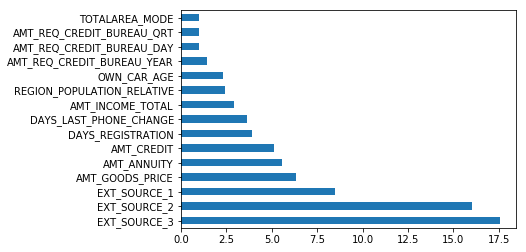

In [34]:
feat_importances = pd.Series(cat.feature_importances_, index=pd.DataFrame(X_train).columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

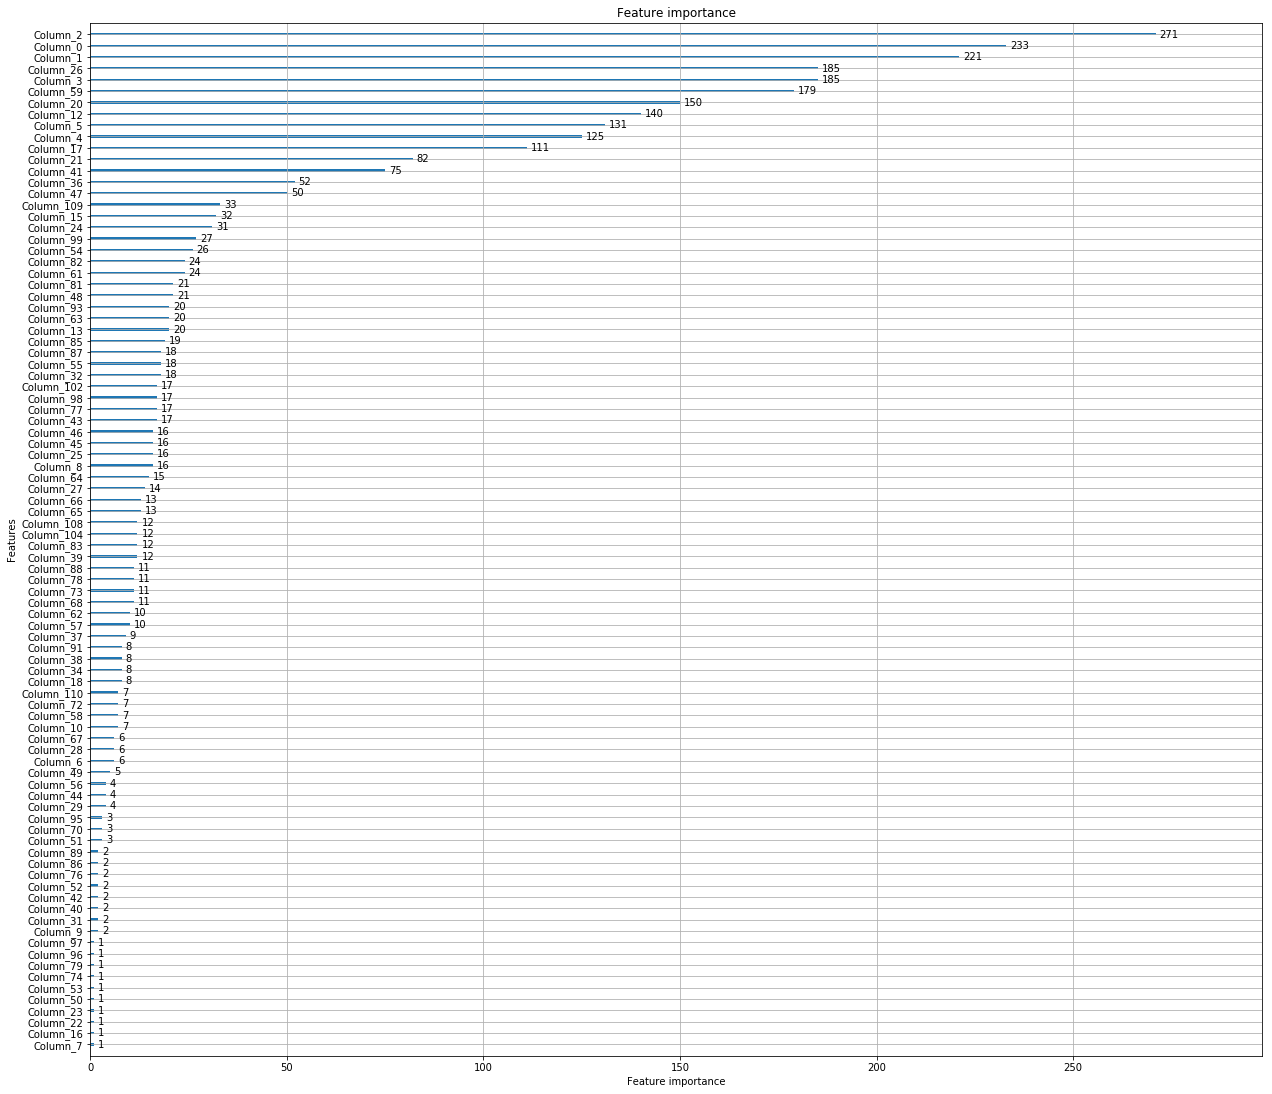

In [43]:
plot_importance(lgbm,figsize = (21,19))